In [28]:
# let's import all the dependencies at once 

from __future__ import print_function
import itertools
import numpy as np
import pandas as pd
import os
import random

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cmatrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.cross_validation import cross_val_score
from sklearn import metrics

#import models
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler


#plots
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
### Read the dataset ###

my_cols = pd.read_csv("KDDlabels.csv", header = -1)

### TRAIN ###
df = pd.read_csv("KDDTrain.csv", header = -1)
df.drop(42, axis=1, inplace=True)
df.columns = my_cols[0] 

# we drop this feature because it is always the same. no information
df.drop("num_outbound_cmds", axis = 1, inplace = True)

### TEST ###
test_df = pd.read_csv("KDDTest.csv", header = -1)
test_df.drop(42, axis = 1, inplace = True)
test_df.columns = my_cols[0]

# we drop this feature because it is always the same. no information
test_df.drop("num_outbound_cmds", axis = 1, inplace = True)

In [30]:
# we add a column that keeps track if a sample comes from the test or train
df["train"] = True
test_df["train"] = False

In [31]:
# TRAIN and TEST merging
mix_df = df.append(test_df)
mix_df.shape

(148516, 42)

In [32]:
mix_df.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,train
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,True
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,True
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,neptune,True


#### Constructing the labels for the 5 class classification ###

In [33]:
mix_df["label_dos"] = mix_df["label"].copy()
mix_df["label_probe"] = mix_df["label"].copy()
mix_df["label_r2l"] = mix_df["label"].copy()
mix_df["label_u2r"] = mix_df["label"].copy()

In [34]:
mix_df.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,train,label_dos,label_probe,label_r2l,label_u2r
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.0,0.0,0.05,0.0,normal,True,normal,normal,normal,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.0,0.0,0.00,0.0,normal,True,normal,normal,normal,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,1.0,1.0,0.00,0.0,neptune,True,neptune,neptune,neptune,neptune


In [35]:
# we are constructing the labels that later will be used to train FOUR different models.

# constructing "label_DOS"
mix_df.loc[~mix_df["label_dos"].isin(["neptune","smurf", "back", "teardrop", "pod", "land", "normal"]), "label_dos"] = 2   # not DOS
mix_df.loc[mix_df["label_dos"].isin(["neptune","smurf", "back", "teardrop", "pod", "land"]), "label_dos"] = 1   # DOS
mix_df.loc[mix_df["label_dos"] == "normal", "label_dos"] = 0   # normal connection


# constructing "label_PROBE"
mix_df.loc[~mix_df["label_probe"].isin(["satan", "ipsweep", "portsweep", "nmap",  "normal"]), "label_probe"] = 2   # not DOS
mix_df.loc[mix_df["label_probe"].isin(["satan", "ipsweep", "portsweep", "nmap"]), "label_probe"] = 1   # DOS
mix_df.loc[mix_df["label_probe"] == "normal", "label_probe"] = 0   # normal connection


# constructing "label_R2L"
mix_df.loc[~mix_df["label_r2l"].isin(["warezclient", "guess_passwd", "warezmaster", "imap","ftp_write", "multihop", "phf", "spy",  "normal"]), "label_r2l"] = 2   # not DOS
mix_df.loc[mix_df["label_r2l"].isin(["warezclient", "guess_passwd", "warezmaster", "imap","ftp_write", "multihop", "phf", "spy"]), "label_r2l"] = 1   # DOS
mix_df.loc[mix_df["label_r2l"] == "normal", "label_r2l"] = 0   # normal connection


# constructing "label_U2R"
mix_df.loc[~mix_df["label_u2r"].isin(["buffer_overflow", "rootkit", "loadmodule", "perl",  "normal"]), "label_u2r"] = 2   # not DOS
mix_df.loc[mix_df["label_u2r"].isin(["buffer_overflow", "rootkit", "loadmodule", "perl"]), "label_u2r"] = 1   # DOS
mix_df.loc[mix_df["label_u2r"] == "normal", "label_u2r"] = 0   # normal connection


y__cv = mix_df[mix_df["train"] == True]
y__cv = y__cv["label"]
y__test = mix_df[mix_df["train"] == False]
y__test = y__test["label"]


mix_df = mix_df.drop("label", axis = 1)

In [37]:
# preparing for the final test

y__cv.loc[~y__cv.isin(["normal"])] = 1   # everything that is not  or normal
y__cv.loc[y__cv == "normal"] = 0   # normal connection
y__cv = pd.to_numeric(y__cv)

y__test.loc[~y__test.isin(["normal"])] = 1   # everything that is not  or normal
y__test.loc[y__test == "normal"] = 0   # normal connection
y__test = pd.to_numeric(y__test)


In [38]:
mix_df["label_dos"] = pd.to_numeric(mix_df["label_dos"])
mix_df["label_probe"] = pd.to_numeric(mix_df["label_probe"])
mix_df["label_r2l"] = pd.to_numeric(mix_df["label_r2l"])
mix_df["label_u2r"] = pd.to_numeric(mix_df["label_u2r"])

In [40]:
# we decide to work with only 13 features

f13 = ["duration", "protocol_type", "service", "src_bytes", "dst_bytes",
       "urgent", "count", "srv_count", "same_srv_rate", "dst_host_count",
       "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_same_src_port_rate",
       "label_dos","label_probe", "label_r2l", "label_u2r", "train"]


restricted_mdf = mix_df.loc[:, f13]
restricted_mdf = pd.get_dummies(data = restricted_mdf, columns = ["protocol_type", "service"])

In [42]:
# creating the TEST and TRAIN dataset that we are going to use

test = restricted_mdf[restricted_mdf["train"] == False]
test = test.drop("train", axis = 1)

#x_test = test.drop("label_numeric", axis = 1)
y_test_dos = test["label_dos"]
y_test_probe = test["label_probe"]
y_test_r2l = test["label_r2l"]
y_test_u2r =  test["label_u2r"]
x_test = test.drop(["label_dos", "label_probe", "label_r2l", "label_u2r"], axis = 1)


x_darpa = restricted_mdf[restricted_mdf["train"] == True]    
x_darpa = x_darpa.drop("train", axis = 1)

y_darpa_dos = x_darpa["label_dos"]
y_darpa_probe = x_darpa["label_probe"]
y_darpa_r2l = x_darpa["label_r2l"]
y_darpa_u2r = x_darpa["label_u2r"]
x_darpa = x_darpa.drop(["label_dos", "label_probe", "label_r2l", "label_u2r"], axis = 1)

In [25]:
### NORMALIZATION ###

columns_to_normalize = ["duration", "src_bytes", "dst_bytes", "count", "srv_count", "dst_host_count", "dst_host_srv_count" ]

## TRAIN normalization
x_darpa_copy = x_darpa.copy()
x_darpa_scaled = x_darpa_copy[columns_to_normalize]
scaler = MinMaxScaler().fit(x_darpa_scaled.values)
x_darpa_scaled = scaler.transform(x_darpa_scaled.values)

x_darpa[columns_to_normalize] = x_darpa_scaled


# TEST normalization
x_test_copy = x_test.copy()
x_test_scaled = x_test_copy[columns_to_normalize]
#scaler = MinMaxScaler().fit(x_darpa_scaled.values)
x_test_scaled = scaler.transform(x_test_scaled.values)           #to transform we use the SCALER calculated in the training

x_test[columns_to_normalize] = x_test_scaled

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## ---Three Classes--- ##

In [43]:
# divido in maniera random (comportamento di default) per DOS
x_train, x_cv, y_train_dos, y_cv_dos = train_test_split(x_darpa, y_darpa_dos, test_size = 0.2, random_state = 42)

# divido in maniera random (comportamento di default) per PROBE
x_train, x_cv, y_train_probe, y_cv_probe = train_test_split(x_darpa, y_darpa_probe, test_size = 0.2, random_state = 42)

# divido in maniera random (comportamento di default) per R2L
x_train, x_cv, y_train_r2l, y_cv_r2l = train_test_split(x_darpa, y_darpa_r2l, test_size = 0.2, random_state = 42)

# divido in maniera random (comportamento di default) per U2R
x_train, x_cv, y_train_u2r, y_cv_u2r = train_test_split(x_darpa, y_darpa_u2r, test_size = 0.2, random_state = 42)

In [13]:
# sample randomly 30000
rows = random.sample(list(y_train.index), 40000)

# set those to a new class, the "don't know" class
y_train.ix[rows] = 2

NameError: name 'y_train' is not defined

In [49]:
y_train_probe.value_counts()

0    53921
2    37558
1     9299
Name: label_probe, dtype: int64

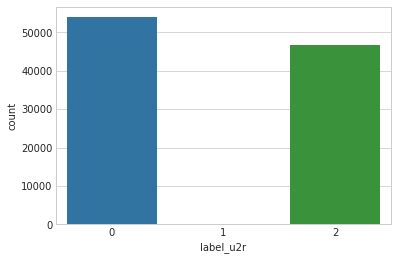

In [46]:
sns.set_style("whitegrid")
sns.countplot(y_train_u2r)
plt.show()

# Random Forest (RF) for DOS#

Random Forest necessita poco preprocessing delle feature. Il target deve essere numerico sequenziale

In [50]:
# cross validation on the training set
clf_dos = RandomForestClassifier(n_jobs = 4, random_state = 42) #Initialize with whatever parameters you want to

In [51]:
#start random forest training
clf_dos.fit(x_train, y_train_dos)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [52]:
predictions_cv_dos = clf_dos.predict(x_cv)
predictions_test_dos = clf_dos.predict(x_test)     # raises error because get_dummy creates features number mismatch

In [53]:
cm_cv_dos = cmatrix(y_cv_dos, predictions_cv_dos).T
cm_test_dos = cmatrix(y_test_dos, predictions_test_dos).T

In [54]:
cm_cv_dos

array([[13413,    10,    27],
       [    7,  9135,    43],
       [    2,    36,  2522]])

In [55]:
cm_test_dos

array([[9423,   53, 4678],
       [  97, 5591,  609],
       [ 190,   97, 1805]])

In [58]:
numeric_evaluation(y_cv_dos, predictions_cv_dos)

Accuracy:  0.995039
Precision: [ 0.99724907  0.99455634  0.98515625]
Recall:    [ 0.99932946  0.99498965  0.97299383]
F1:        [ 0.99828818  0.99477295  0.97903727]


In [59]:
numeric_evaluation(y_test_dos, predictions_test_dos)

Accuracy:  0.746085
Precision: [ 0.6657482   0.88788312  0.86281071]
Recall:    [ 0.97044284  0.97387215  0.25451213]
F1:        [ 0.78972511  0.92889184  0.39307491]


# Random Forest (RF) for PROBE #

Random Forest necessita poco preprocessing delle feature. Il target deve essere numerico sequenziale

In [60]:
# cross validation on the training set
clf_probe = RandomForestClassifier(n_jobs = 4, random_state = 42) #Initialize with whatever parameters you want to

In [61]:
#start random forest training
clf_probe.fit(x_train, y_train_probe)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [62]:
predictions_cv_probe = clf_probe.predict(x_cv)
predictions_test_probe = clf_probe.predict(x_test)     # raises error because get_dummy creates features number mismatch

In [63]:
cm_cv_probe = cmatrix(y_cv_probe, predictions_cv_probe).T
cm_test_probe = cmatrix(y_test_probe, predictions_test_probe).T

In [67]:
cm_cv_probe

array([[13409,    14,    30],
       [    3,  2303,    39],
       [   10,    40,  9347]])

In [68]:
cm_test_probe

array([[9432,    3, 4754],
       [ 180, 1082,  450],
       [  98,   21, 6523]])

In [69]:
numeric_evaluation(y_cv_probe, predictions_cv_probe)

Accuracy:  0.994602
Precision: [ 0.99672935  0.98208955  0.99467915]
Recall:    [ 0.99903144  0.97708952  0.99267205]
F1:        [ 0.99787907  0.97958316  0.99367459]


In [70]:
numeric_evaluation(y_test_probe, predictions_test_probe)

Accuracy:  0.755756
Precision: [ 0.66474029  0.63200935  0.98208371]
Recall:    [ 0.97136972  0.97830018  0.55623774]
F1:        [ 0.78932173  0.76792051  0.7102183 ]


# Random Forest (RF) for R2L#

Random Forest necessita poco preprocessing delle feature. Il target deve essere numerico sequenziale

In [71]:
# cross validation on the training set
clf_r2l = RandomForestClassifier(n_jobs = 4, random_state = 42) #Initialize with whatever parameters you want to

In [72]:
#start random forest training
clf_r2l.fit(x_train, y_train_r2l)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [73]:
predictions_cv_r2l = clf_r2l.predict(x_cv)
predictions_test_r2l = clf_r2l.predict(x_test)     

In [74]:
cm_cv_r2l = cmatrix(y_cv_r2l, predictions_cv_r2l).T
cm_test_r2l = cmatrix(y_test_r2l, predictions_test_r2l).T

In [75]:
cm_cv_r2l

array([[13409,    13,    30],
       [    1,   211,     1],
       [   12,     0, 11518]])

In [76]:
cm_test_r2l

array([[9432, 1988, 2898],
       [   2,  198,    2],
       [ 276,   13, 7734]])

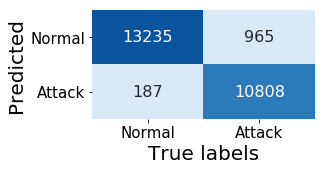

In [91]:
#confusion matrices

matrix_evaluation(cm_cv)
#matrix_evaluation(cm_test)

In [77]:
numeric_evaluation(y_cv_r2l, predictions_cv_r2l)

Accuracy:  0.997738
Precision: [ 0.99680345  0.99061033  0.99895924]
Recall:    [ 0.99903144  0.94196429  0.99731578]
F1:        [ 0.9979162   0.96567506  0.99813683]


In [78]:
numeric_evaluation(y_test_r2l, predictions_test_r2l)

Accuracy:  0.770261
Precision: [ 0.65875122  0.98019802  0.96397856]
Recall:    [ 0.97136972  0.09004093  0.72728983]
F1:        [ 0.78508407  0.16493128  0.8290722 ]


# Random Forest (RF) for U2R #

Random Forest necessita poco preprocessing delle feature. Il target deve essere numerico sequenziale

In [79]:
# cross validation on the training set
clf_u2r = RandomForestClassifier(n_jobs = 4, random_state = 42) #Initialize with whatever parameters you want to

In [80]:
#start random forest training
clf_u2r.fit(x_train, y_train_u2r)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [81]:
predictions_cv_u2r = clf_u2r.predict(x_cv)
predictions_test_u2r = clf_u2r.predict(x_test)     

In [82]:
cm_cv_u2r = cmatrix(y_cv_u2r, predictions_cv_u2r).T
cm_test_u2r = cmatrix(y_test_u2r, predictions_test_u2r).T

In [83]:
cm_cv_u2r

array([[13407,     7,    29],
       [    1,     4,     0],
       [   14,     0, 11733]])

In [84]:
cm_test_u2r

array([[9342,   36, 4760],
       [   1,    1,    2],
       [ 367,    0, 8034]])

In [85]:
numeric_evaluation(y_cv_u2r, predictions_cv_u2r)

Accuracy:  0.997976
Precision: [ 0.99732203  0.8         0.99880821]
Recall:    [ 0.99888243  0.36363636  0.99753443]
F1:        [ 0.99810162  0.5         0.99817091]


In [86]:
numeric_evaluation(y_test_u2r, predictions_test_u2r)

Accuracy:  0.770838
Precision: [ 0.66077239  0.25        0.95631472]
Recall:    [ 0.96210093  0.02702703  0.62785245]
F1:        [ 0.78346193  0.04878049  0.7580318 ]


# Support Vector Machine (SVM) #

In [94]:
# divido in maniera random tra train e test(comportamento di default)

x_train, x_cv, y_train, y_cv = train_test_split(x_darpa, y_darpa, test_size=0.2, random_state=42)

In [95]:
clf = svm.SVC(gamma = 0.001, C = 100)

In [96]:
# model training
clf.fit(x_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
predictions_cv = clf.predict(x_cv)
#predictions_test = clf.predict(x_test)

In [98]:
cm_cv = cmatrix(y_cv, predictions_cv).T
#cm_test = cmatrix(y_test, predictions_test).T

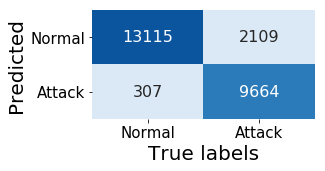

In [99]:
#confusion matrices

matrix_evaluation(cm_cv)
#matrix_evaluation(cm_test)

In [100]:
# in cross-validation
numeric_evaluation(y_cv, predictions_cv)

Accuracy:  0.904108
Precision: [ 0.86146873  0.96921071]
Recall:    [ 0.9771271   0.82086129]
F1:        [ 0.91566013  0.88888889]


In [41]:
# in test
numeric_evaluation(y_test, predictions_test)

Accuracy:  0.982568
Precision: [ 0.97189506  0.99550451]
Recall:    [ 0.99619857  0.96691114]
F1:        [ 0.98389675  0.98099952]


# Logistic Regression (LR) #

puo' essere che funzioni solo con 2 classi

In [28]:
# divido in maniera random tra train e test(comportamento di default)

x_train, x_cv, y_train, y_cv = train_test_split(x_darpa, y_darpa, test_size=0.2, random_state=42)

In [29]:
clf = LogisticRegression(random_state=42)

In [30]:
# model training
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
predictions_cv = clf.predict(x_cv)
predictions_test = clf.predict(x_test)

In [32]:
cm_cv = cmatrix(y_cv, predictions_cv).T
cm_test = cmatrix(y_test, predictions_test).T

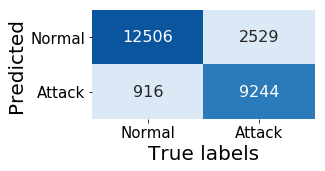

In [33]:
matrix_evaluation(cm_cv)

In [34]:
numeric_evaluation(y_cv, predictions_cv)

Accuracy:  0.863267
Precision: [ 0.83179248  0.90984252]
Recall:    [ 0.93175384  0.78518644]
F1:        [ 0.87894016  0.84293074]


In [35]:
numeric_evaluation(y_test, predictions_test)

Accuracy:  0.866043
Precision: [ 0.83570136  0.91093396]
Recall:    [ 0.93280668  0.78935698]
F1:        [ 0.88158809  0.84579888]


# Naive Bayes #

In [55]:
# divido in maniera random tra train e test(comportamento di default)

x_train, x_cv, y_train, y_cv = train_test_split(x_darpa, y_darpa, test_size=0.2, random_state=42)

In [12]:
clf = GaussianNB()

In [13]:
clf.fit(x_train, y_train)

GaussianNB(priors=None)

In [18]:
predictions_cv = clf.predict(x_cv)
predictions_test = clf.predict(x_test)

In [19]:
cm_cv = cmatrix(y_cv, predictions_cv).T
cm_test = cmatrix(y_test, predictions_test).T

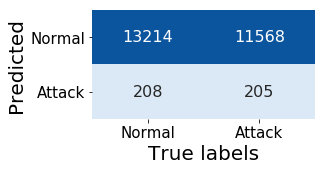

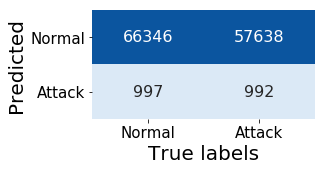

In [22]:
#confusion matrices

matrix_evaluation(cm_cv)
matrix_evaluation(cm_test)

In [23]:
# in cross-validation
numeric_evaluation(y_cv, predictions_cv)

Accuracy:  0.532606
Precision: [ 0.53320959  0.49636804]
Recall:    [ 0.98450305  0.01741272]
F1:        [ 0.69176003  0.03364517]


In [25]:
# in test set
numeric_evaluation(y_test, predictions_test)

Accuracy:  0.534543
Precision: [ 0.53511743  0.49874309]
Recall:    [ 0.98519519  0.01691967]
F1:        [ 0.69353515  0.03272901]


# K Nearest Neighbor (KNN) #

In [22]:
clf = KNeighborsClassifier()
clf.fit(x_train, y_train)

# make predictions
predictions_cv = clf.predict(x_cv)
predictions_test = clf.predict(x_test)

In [23]:
cm_cv = cmatrix(y_cv, predictions_cv).T
cm_test = cmatrix(y_test, predictions_test).T

In [24]:
cm_cv

array([[9307,   78,    0],
       [  86, 7928,    0],
       [4029, 3767,    0]])

In [25]:
cm_test

array([[6244, 3243,    0],
       [ 249, 5494,    0],
       [3217, 4096,    0]])

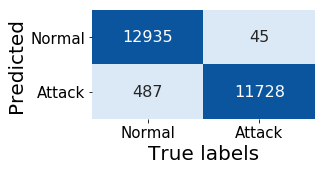

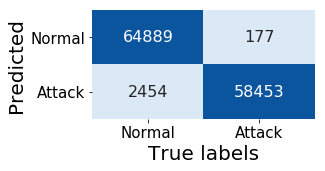

In [81]:
# confusion matrices
matrix_evaluation(cm_cv)
matrix_evaluation(cm_test)

In [26]:
# in cross-validation
numeric_evaluation(y_cv, predictions_cv)

Accuracy:  0.684064
Precision: [ 0.99168887  0.98926878  0.        ]
Recall:    [ 0.6934138   0.67340525  0.        ]
F1:        [ 0.81615294  0.80133421  0.        ]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [83]:
numeric_evaluation(y_test, predictions_test)

Accuracy:  0.979115
Precision: [ 0.99727969  0.95970906]
Recall:    [ 0.96355969  0.99698107]
F1:        [ 0.98012975  0.97799008]


# Evaluation #

In [57]:
# print a nice confusion matrix
def matrix_evaluation(cm):

    fig, ax = plt.subplots(figsize=(4,2))

    sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt=".0f", cbar=False, cmap=sns.color_palette("Blues"))

    # labels, title and ticks
    ax.set_xlabel('True labels', fontsize=20)
    ax.set_ylabel('Predicted', fontsize=20)


    ax.xaxis.set_ticklabels(['Normal', 'Attack'], fontsize=15)
    ax.yaxis.set_ticklabels(['Normal', 'Attack'], fontsize=15)

    plt.yticks(rotation=0)
    plt.show()

def numeric_evaluation(y_cv, predictions):
    
    print("Accuracy:  %f" %accuracy_score(y_cv, predictions))
    print("Precision: %s" %precision_score(y_cv, predictions, average=None))
    print("Recall:    %s" %recall_score(y_cv, predictions, average=None))
    print("F1:        %s" %f1_score(y_cv, predictions, average=None))
    

# Missclassified Analysis #

In [77]:
x_cv_analysis = x_cv.copy()

In [99]:
#"neptune","smurf", "back", "teardrop", "pod", "land"

x_cv_analysis.loc[:, "TRUTH"] = df.loc[x_cv.index, "label"]
#x_cv_analysis.replace(to_replace="normal", value=0, inplace=True)
#x_cv_analysis.replace(to_replace=["neptune","smurf", "back", "teardrop", "pod", "land"], value = 1, inplace=True)

x_cv_analysis.loc[:, "PREDICTION"] = clf.predict(x_cv)
#x_cv_analysis.loc[:, "GUESSED"] = False
x_cv_analysis.loc[:, "GUESSED"] = x_cv_analysis.loc[:, "TRUTH"].isin([1]) & x_cv_analysis.loc[:, "PREDICTION"].isin([0])

In [85]:
x_cv_analysis.head()

,duration,src_bytes,dst_bytes,urgent,count,srv_count,same_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,...,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,TRUTH,PREDICTION,GUESSED
378,0.0,2.608764e-08,0.0,0,0.003914,0.007828,1.00,0.262745,0.670588,1.00,...,0,0,0,0,0,0,0,0,2,False
32038,0.0,0.000000e+00,0.0,0,0.082192,0.021526,0.26,1.000000,0.172549,0.17,...,0,0,0,0,0,0,0,1,2,False
86399,0.0,0.000000e+00,0.0,0,0.555773,0.039139,0.07,1.000000,0.078431,0.08,...,0,0,0,0,0,0,0,1,1,True
74412,0.0,0.000000e+00,0.0,0,0.215264,0.015656,0.07,1.000000,0.105882,0.11,...,0,0,0,0,0,0,0,1,2,False
52951,0.0,0.000000e+00,0.0,0,0.001957,0.001957,1.00,0.525490,0.003922,0.01,...,0,0,0,0,0,0,0,portsweep,2,False


In [38]:
x_cv_analysis["GUESSED"].value_counts()

True     25087
False      108
Name: GUESSED, dtype: int64

In [39]:
#show the proability of each prediction
clf.predict_proba(x_cv)

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]])

# COMBINING MODELS #

In [91]:
# we now are going to coming the FOUR models to predict if a sample is NORMAL or ATTACK.
# We classify as ATTACK if at least one model flags the sample as a threat, and NORMAL if ALL the models say that it is NORMAL.
# the remaning cases are classified as DONT KNOW


x_cv_analysis = x_cv.copy()
x_test_analysis = x_test.copy()

# CV
x_cv_analysis["prediction_dos"] = predictions_cv_dos
x_cv_analysis["prediction_probe"] = predictions_cv_probe
x_cv_analysis["prediction_r2l"] = predictions_cv_r2l
x_cv_analysis["prediction_u2r"] = predictions_cv_u2r

# TEST
x_test_analysis["prediction_dos"] = predictions_test_dos
x_test_analysis["prediction_probe"] = predictions_test_probe
x_test_analysis["prediction_r2l"] = predictions_test_r2l
x_test_analysis["prediction_u2r"] = predictions_test_u2r

In [92]:
att_cv = (x_cv_analysis["prediction_dos"] == 1) | (x_cv_analysis["prediction_probe"] == 1) | (x_cv_analysis["prediction_r2l"] == 1) | (x_cv_analysis["prediction_u2r"] == 1)
norm_cv = (x_cv_analysis["prediction_dos"] == 0) & (x_cv_analysis["prediction_probe"] == 0) & (x_cv_analysis["prediction_r2l"] == 0) & (x_cv_analysis["prediction_u2r"] == 0)


att_test = (x_test_analysis["prediction_dos"] == 1) | (x_test_analysis["prediction_probe"] == 1) | (x_test_analysis["prediction_r2l"] == 1) | (x_test_analysis["prediction_u2r"] == 1)
norm_test = (x_test_analysis["prediction_dos"] == 0) & (x_test_analysis["prediction_probe"] == 0) & (x_test_analysis["prediction_r2l"] == 0) & (x_test_analysis["prediction_u2r"] == 0)

In [93]:
# CV
x_cv_analysis["prediction_final"] = 2
x_cv_analysis.loc[att_cv.values, "prediction_final"] = 1
x_cv_analysis.loc[norm_cv.values, "prediction_final"] = 0

# TEST
x_test_analysis["prediction_final"] = 2
x_test_analysis.loc[att_test.values, "prediction_final"] = 1
x_test_analysis.loc[norm_test.values, "prediction_final"] = 0

In [94]:
x_cv_analysis.head(10)

,duration,src_bytes,dst_bytes,urgent,count,srv_count,same_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,...,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,prediction_dos,prediction_probe,prediction_r2l,prediction_u2r,prediction_final
378,0,36,0,0,2,4,1.00,67,171,1.00,...,0,0,0,0,0,0,0,0,0,0
32038,0,0,0,0,42,11,0.26,255,44,0.17,...,0,0,0,0,0,1,2,2,2,1
86399,0,0,0,0,284,20,0.07,255,20,0.08,...,0,0,0,0,0,1,2,2,2,1
74412,0,0,0,0,110,8,0.07,255,27,0.11,...,0,0,0,0,0,1,2,2,2,1
52951,0,0,0,0,1,1,1.00,134,1,0.01,...,0,0,0,0,0,2,1,2,2,1
62143,0,325,4673,0,20,20,1.00,255,255,1.00,...,0,0,0,0,0,0,0,0,0,0
21449,0,0,0,0,133,13,0.10,255,33,0.13,...,0,0,0,0,0,1,2,2,2,1
120009,0,0,0,0,101,17,0.17,255,17,0.07,...,0,0,0,0,0,1,2,2,2,1
34191,0,0,0,0,285,18,0.06,255,18,0.07,...,0,0,0,0,0,1,2,2,2,1
66591,0,743,335,0,1,2,1.00,138,85,0.62,...,0,0,0,0,0,0,0,0,0,0


In [95]:
x_test_analysis["prediction_final"].value_counts()

0    13397
1     8205
2      941
Name: prediction_final, dtype: int64

In [96]:
x_cv_analysis["prediction_final"].value_counts()

0    13423
1    11740
2       32
Name: prediction_final, dtype: int64

In [97]:
# per CV
cm_cv_final = cmatrix(y__cv.loc[x_cv_analysis.index], x_cv_analysis["prediction_final"]).T
cm_cv_final

array([[13399,    24,     0],
       [   11, 11729,     0],
       [   12,    20,     0]])

In [98]:
cm_test_final = cmatrix(y__test, x_test_analysis["prediction_final"]).T
cm_test_final

array([[9322, 4075,    0],
       [ 278, 7927,    0],
       [ 110,  831,    0]])

In [ ]:
DA MIGLIORARE:

array([[9322, 4075,    0],
       [ 278, 7927,    0],
       [ 110,  831,    0]])

In [ ]:
forse è colpa delle classi sbilanciate?
forse piu feature preprocessing?